# Data preparation

The goal of this stage in the analysis is to check the data for errors and identify the functional forms in which the explanatory variables should enter the model and any important interaction terms that should be included in the model.

## Imports

In [1]:
# standard imports
from pathlib import Path
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from math import floor

# set custom module path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import custom scripts
import src.visualize as vsl

## Import data

In [2]:
from pathlib import Path
from src.functions import savetable

data_dir = Path("../data/raw/")
data_file = data_dir / "ca-schools.csv"

df = pd.read_csv(data_file, index_col=0)
df.head()

savetable(df.head(10), "01-raw-data-table.tex")

C:\Users\gfitz\OneDrive\Desktop\projects\ca-schools\src\functions.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  string = table.to_latex()


## Data descriptions

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 1 to 420
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   district     420 non-null    int64  
 1   school       420 non-null    object 
 2   county       420 non-null    object 
 3   grades       420 non-null    object 
 4   students     420 non-null    int64  
 5   teachers     420 non-null    float64
 6   calworks     420 non-null    float64
 7   lunch        420 non-null    float64
 8   computer     420 non-null    int64  
 9   expenditure  420 non-null    float64
 10  income       420 non-null    float64
 11  english      420 non-null    float64
 12  read         420 non-null    float64
 13  math         420 non-null    float64
dtypes: float64(8), int64(3), object(3)
memory usage: 49.2+ KB


The dataset comes from all K-6 and K-8 school districts in California with data available from 1998 and 1999. It consists of 420 observations on 14 variables. We are interested in determining the school characteristics and student demographics variables that best explain student performance in math. 

Our response variable is **math**, the school's average math score on the Stanford 9 standardized test administered to 5th graders. The explanatory variables of interest consist of the following school characteristics and student demographic background measures

**students** - the total district enrollment

**teachers** - the total number of teachers (considered "full-time equivalents) in the district

**computer** - the total number of computers in the district

**expenditure** - the average expenditures per student in the district

**calworks** - the percentage of students in the public income assistance program CalWorks

**lunch** - the percentage of students that qualify for reduced-price lunch

**english** - the percentage of students that are English language learners

**income** - the average district income (in USD 1,000)

All of the variables of interest are quantitative.

**NOTE:** In the source descriptions of the data, students, teachers, and computer are *misclassified* as *averages* across the district. Checking alternative historical records for a sample of the observed districts revealed that these variables actually measure the district *totals*.

At this point, the irrelevant variables may be safely dropped from the dataset.

In [4]:
df.drop(columns=['district', 'school', 'county', 'grades', 'read'], inplace=True)

df.head()

savetable(df.head(10), "02-data-table.tex")

C:\Users\gfitz\AppData\Local\Temp\ipykernel_17648\628592681.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  string = table.to_latex()


## Data screening

In [5]:
for col in df.columns:
    print(col, df[col].nunique(), df[col].count(), df[col].dtypes)

students 391 420 int64
teachers 374 420 float64
calworks 411 420 float64
lunch 407 420 float64
computer 270 420 int64
expenditure 420 420 float64
income 337 420 float64
english 372 420 float64
math 324 420 float64


None of the variables contain missing values. 

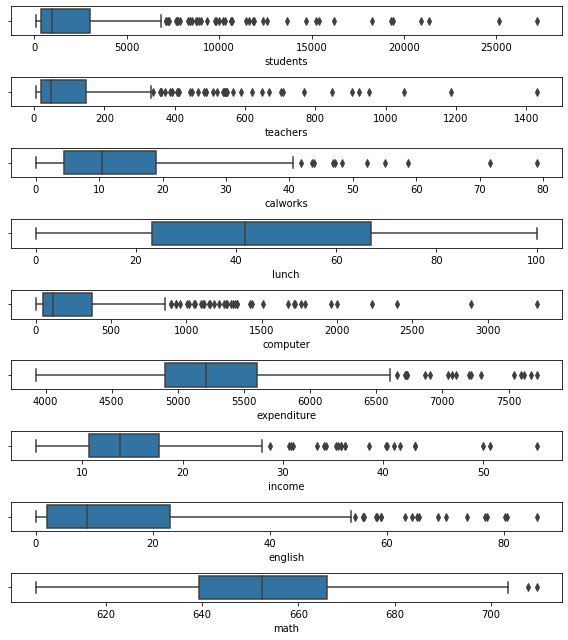

In [6]:
ax = vsl.boxplots(df)

fig_path = Path("../reports/figures/")
fig_name = "03-boxplots.png"

plt.savefig(fig_path / fig_name)

The boxplots show a significant number of positive outliers in all of the explanatory variables except lunch. Two positive outlying cases are discernable in the response as well. No evidence suggests that these extreme cases resulted from an error in recording, so the outliers should be analyzed for influence at a later stage in the analysis.

## Diagnostics for relationships and strong interactions

Now we will examine the functional relationships between the explanatory variables and the response as well as the strengths of the relationships.

### Scatterplot matrix

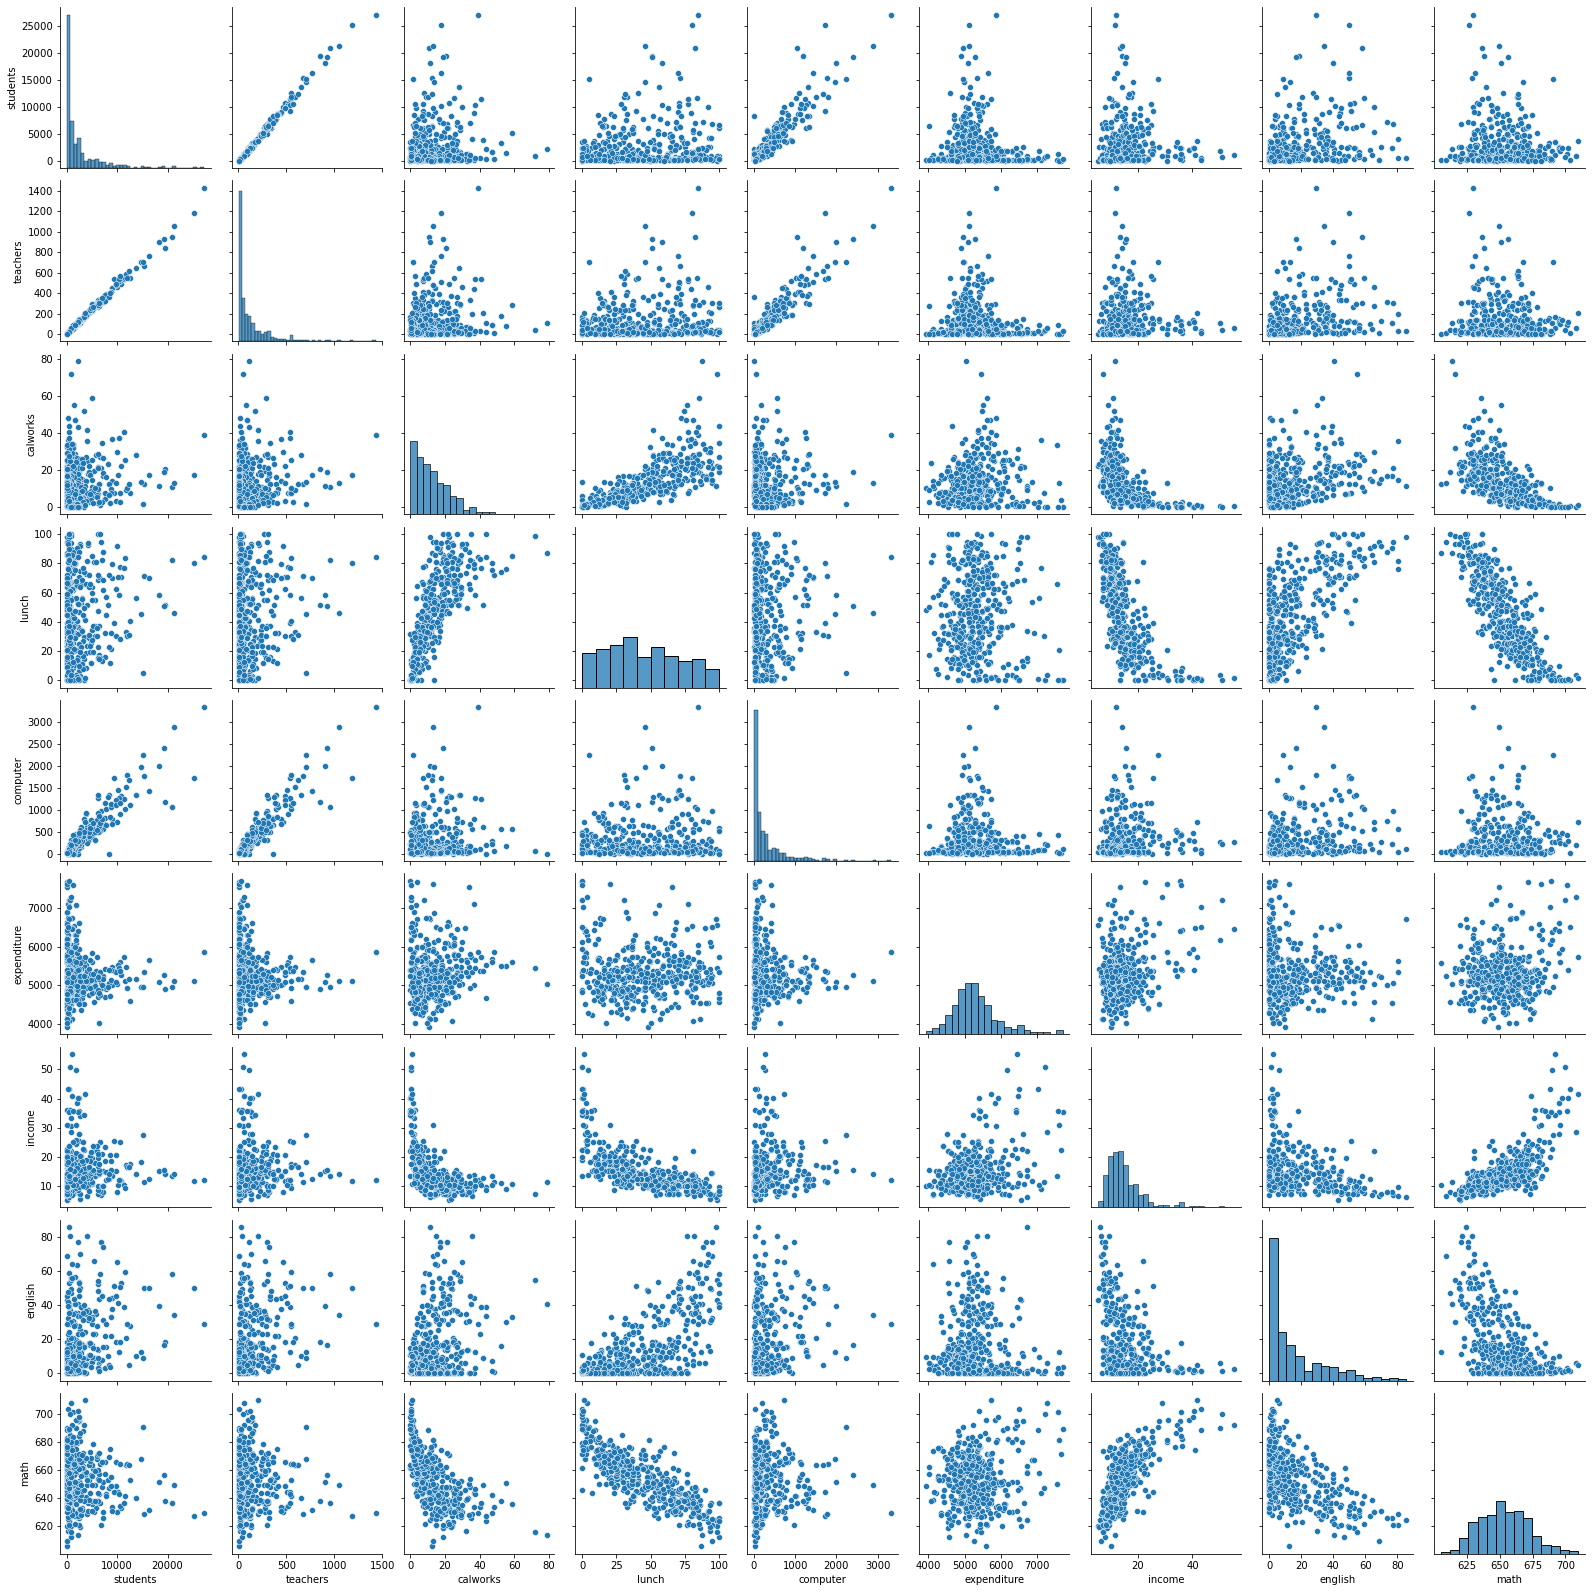

In [7]:
ax = sns.pairplot(df)

fig_name = "04-scatterplot-matrix.png"
plt.savefig(fig_path / fig_name)

The scatterplots of the response against calworks and income show some evidence of curvature. The scatterplots of the response against students, teachers, calworks, and computer show a couple moderately outlying points. Scatterplots of the predictors against each other also reveal some potential outliers.

### Correlation matrix

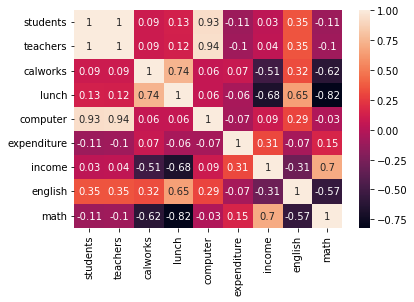

In [8]:
corrmat = df.corr().round(2)
ax = sns.heatmap(corrmat, annot=True)

fig_name = "05-correlation-matrix.png"

plt.savefig(fig_path / fig_name)

The correlation matrix shows that calworks, lunch, income, and english exhibit moderately strong linear relationships to the response, while students, teachers, computer, and expenditure exhibit little to no relationship with the response. Both the scatterplot matrix and the correlation matrix reveal strong intercorrelations among the predictors, with students, teachers, and computers having near perfect pairwise correlations. The effects of multicollinearity should be examined more closely at a later stage in the analysis.

### Residual plots

We will now fit an additive ordinary least squares model to the data to further examine the functional relationships between the predictors and the response.

In [9]:
fm1 = "math ~ students + teachers + calworks + lunch + computer + expenditure + income + english"

y1, X1 = dmatrices(fm1, data=df, return_type='dataframe')

mod1 = sm.OLS(y1, X1)
res1 = mod1.fit()

print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                   math   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     135.5
Date:                Thu, 28 Jul 2022   Prob (F-statistic):          3.40e-110
Time:                        13:51:51   Log-Likelihood:                -1555.5
No. Observations:                 420   AIC:                             3129.
Df Residuals:                     411   BIC:                             3165.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     656.1499      4.487    146.227      

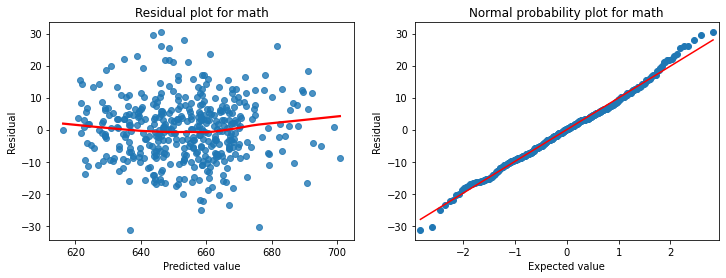

In [10]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

sns.regplot(x=res1.fittedvalues, y=res1.resid, lowess=True, line_kws={'color': 'r'}, ax=ax[0]);
ax[0].set_xlabel("Predicted value");
ax[0].set_ylabel("Residual");
ax[0].set_title("Residual plot for math");

sm.graphics.qqplot(res1.resid, line='r', ax=ax[1]);
ax[1].set_xlabel("Expected value");
ax[1].set_ylabel("Residual");
ax[1].set_title("Normal probability plot for math");


fig_name = "06-residuals-base-model"
plt.savefig(fig_path / fig_name)

The residual plot against the predicted values shows a slight tendency for the residuals to be positive for smaller and larger values, which indicates a potential non-linear regression relationship or the omission of one or more important variables. It gives little to no evidence for non-constant error variance. There appear to be a few outlying data points. 

The normal probability plot is approximately linear, but there appear to be small departures from normality at the tails.

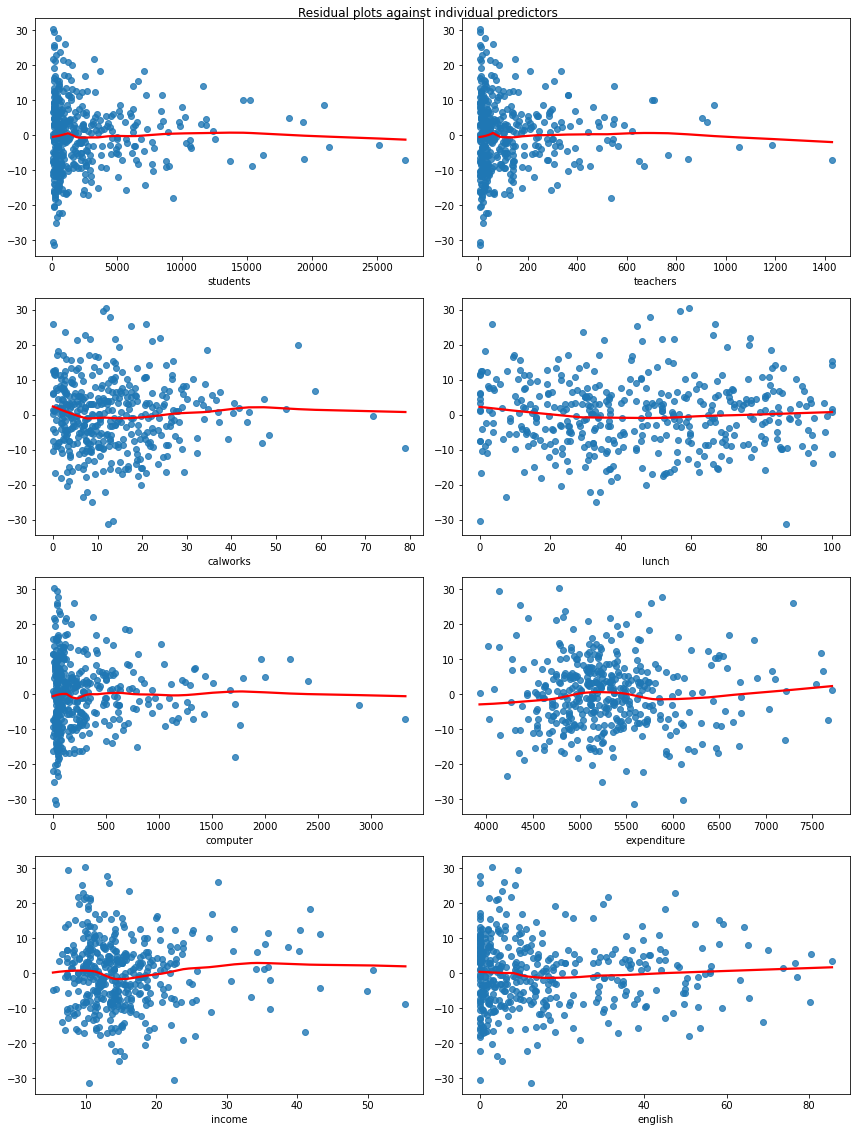

In [11]:
fig, ax = plt.subplots(4, 2, tight_layout=True)
fig.set_size_inches(12, 16)

predictors = X1.drop(columns="Intercept").columns

i = 0
for p in predictors:
    row = floor(i / 2)
    col = i % 2
    
    sns.regplot(x=X1[p], y=res1.resid, ax=ax[row, col], lowess=True, line_kws={'color': 'r'})
    
    i += 1
    
fig.suptitle("Residual plots against individual predictors");

fig_name = "07-residuals-base-model"
plt.savefig(fig_path / fig_name)

The residual plots show a slight tendency for the residuals to be positive, negative, and then positive for increasing values of calworks and income. There also appears to be some systematic variation in the residuals with respect to expenditure. The residual plots also show a tendency for the residuals to decrease in magnitude for increasing values of students, teachers, calworks, computer, income, and english, indicating some heteroskedascity. The plots further indicate the presense of outliers. 

At this point, there is evidence for some curvature in the response with respect to calworks, income, and english.

### Added-variable plots

To examine the power terms or interactions that may be related to the response in important ways, we will construct added-variable plots.

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


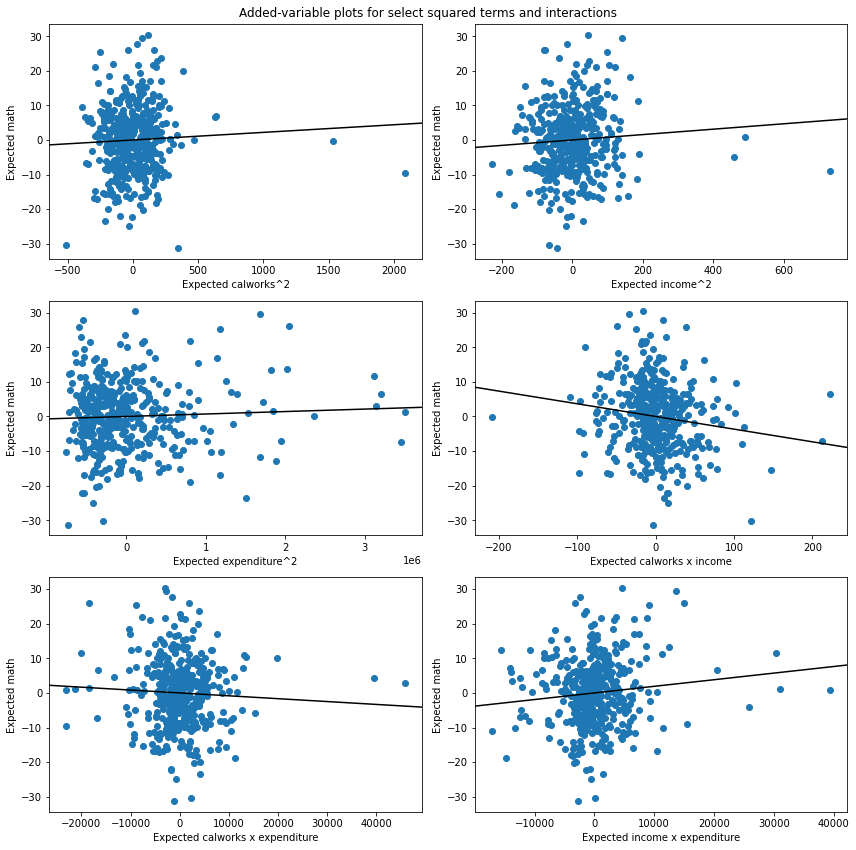

In [12]:
fig, ax = plt.subplots(3, 2, tight_layout=True)
fig.set_size_inches(12, 12)

sm.graphics.plot_partregress(y1, np.square(df['calworks']), X1, ax=ax[0,0], obs_labels=False);
ax[0,0].set_xlabel("Expected calworks^2")
ax[0,0].set_ylabel("Expected math")
ax[0,0].set_title(None)

sm.graphics.plot_partregress(y1, np.square(df['income']), X1, ax=ax[0,1], obs_labels=False);
ax[0,1].set_xlabel("Expected income^2")
ax[0,1].set_ylabel("Expected math")
ax[0,1].set_title(None)

sm.graphics.plot_partregress(y1, np.square(df['expenditure']), X1, ax=ax[1,0], obs_labels=False);
ax[1,0].set_xlabel("Expected expenditure^2")
ax[1,0].set_ylabel("Expected math")
ax[1,0].set_title(None)

sm.graphics.plot_partregress(y1, (df['calworks']*df['income']), X1, ax=ax[1,1], obs_labels=False);
ax[1,1].set_xlabel("Expected calworks x income")
ax[1,1].set_ylabel("Expected math")
ax[1,1].set_title(None)

sm.graphics.plot_partregress(y1, (df['calworks']*df['expenditure']), X1, ax=ax[2,0], obs_labels=False);
ax[2,0].set_xlabel("Expected calworks x expenditure")
ax[2,0].set_ylabel("Expected math")
ax[2,0].set_title(None)

sm.graphics.plot_partregress(y1, (df['income']*df['expenditure']), X1, ax=ax[2,1], obs_labels=False);
ax[2,1].set_xlabel("Expected income x expenditure")
ax[2,1].set_ylabel("Expected math")
ax[2,1].set_title(None)

fig.suptitle("Added-variable plots for select squared terms and interactions")

fig_name="08-added-variable-base-model.png"
plt.savefig(fig_path / fig_name)

The added-variable plots show that including second-order terms for calworks and income and interaction terms for calworks, income, and expenditure may have added value for the model.

In [13]:
fm2 = """math ~ students + teachers + calworks + np.square(calworks) + lunch + computer 
      + expenditure + income + np.square(income) + english + calworks:income
      + calworks:expenditure + expenditure:income"""

y2, X2 = dmatrices(fm2, data=df, return_type='dataframe')

mod2 = sm.OLS(y2, X2)
res2 = mod2.fit()

print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                   math   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     86.57
Date:                Thu, 28 Jul 2022   Prob (F-statistic):          3.12e-108
Time:                        13:51:54   Log-Likelihood:                -1547.9
No. Observations:                 420   AIC:                             3124.
Df Residuals:                     406   BIC:                             3180.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              673.6843 

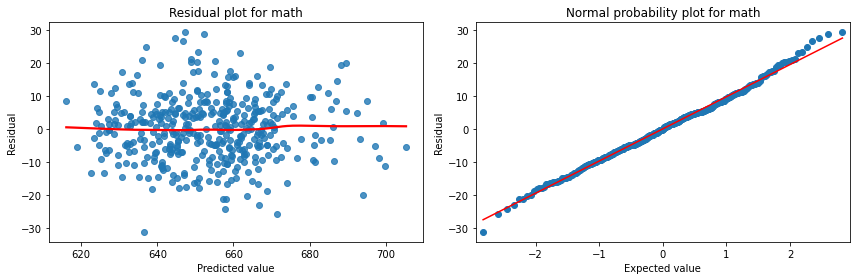

In [14]:
fig, ax = plt.subplots(1, 2, tight_layout=True)
fig.set_size_inches(12, 4)

sns.regplot(x=res2.fittedvalues, y=res2.resid, lowess=True, line_kws={'color': 'r'}, ax=ax[0]);
ax[0].set_xlabel("Predicted value");
ax[0].set_ylabel("Residual");
ax[0].set_title("Residual plot for math");

sm.graphics.qqplot(res2.resid, line='r', ax=ax[1]);
ax[1].set_xlabel("Expected value");
ax[1].set_ylabel("Residual");
ax[1].set_title("Normal probability plot for math");

fig_name = "09-residuals-full-model.png"
plt.savefig(fig_path / fig_name)

The residuals show no systematic tendency to be positive or negative with respect to the fitted values. The magnitude of the residuals does not appear to vary in any significant way for increasing fitted values. Some outlying cases are still evident. The normal probability plots shows little to no deparatures from normality.

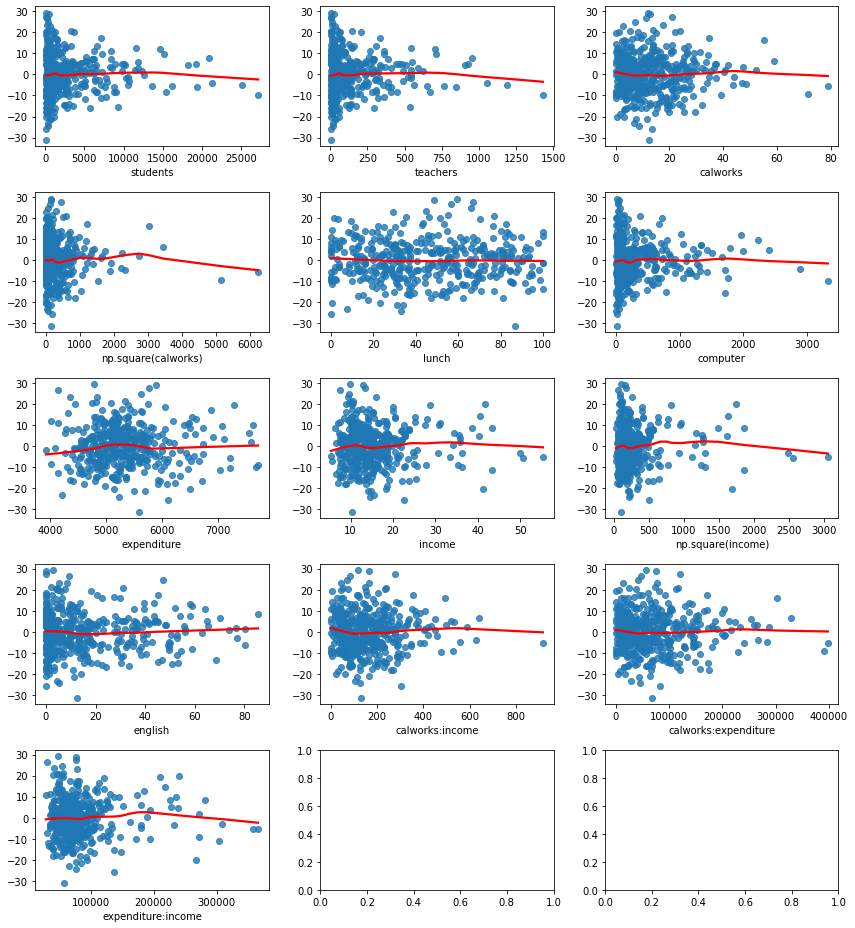

In [15]:
ax = vsl.scatterplots(X2.drop(columns='Intercept'), res2.resid)

fig_name = "10-residuals-full-model.png"

The residuals plots show no clear patterns of systematic variation about 0, indicating that the functional forms in the model are reasonably appropriate. There is still some evidence for non-constant error variance. Heteroskedascity should be further examined after we reduce the number of explanatory variables in the next stage of the analysis.

### Boxplot of residuals

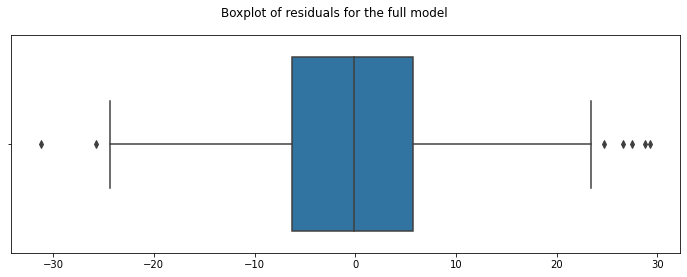

In [16]:
fig = plt.figure()
fig.set_figwidth(12)

sns.boxplot(x=res2.resid);
fig.suptitle("Boxplot of residuals for the full model")

fig_name = "11-boxplot-residuals-full-model.png"
plt.savefig(fig_path / fig_name)

The residuals boxplot show several outlying cases that should be examined for influence.

## Summary
At this point, the current model seems appropriate. The second-order terms and interactions seem to account for much of the observed curvature. Diagnostic plots and tests provide no evidence that the errors depart from normality. Residual plots suggest some heteroscedascity, which indicates that a weighted least squares approach may help later on. Reducing the number of explanatory variables may help to mitigate the observed multicollinearity. Furthermore, centering the the predictors will help to reduce intercorrelations introduced by the interaction terms. Outliers still need to be examined for influence.

## Center and write processed data to new file

Before reducing the number of explanatory variables and selecting a few good candidate subsets, we will center the data to reduce multicollinearity introduced by including second-order terms in the model.

In [17]:
predictors = ['students', 'teachers', 'calworks', 'lunch', 'computer', 'expenditure', 'income', 'english']

for pred in predictors:
    df[pred] = df[pred] - df[pred].mean()
    
df.head()

savetable(df, "12-transformed-data-table.tex")

C:\Users\gfitz\AppData\Local\Temp\ipykernel_17648\628592681.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  string = table.to_latex()


In [18]:
data_dir = Path("../data/processed/")
data_file = data_dir / "ca-schools.csv"

df.to_csv(data_file, index=False)